In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

In [5]:
device = torch.device("cuda")
device

device(type='cuda')

# Loada Data

In [62]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.2),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root ="data/train/", transform=train_transform)

total_size = len(dataset)
train_size = int(0.95 * total_size)
val_size = total_size - train_size

# Split the dataset
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 64

# DataLoader for the training set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# DataLoader for the validation set
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [63]:
len(dataset.classes)
len(dataset)

88011

In [64]:
def get_accuracy(model: nn.Module, data_loader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

# Model

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=2)
        self.batch1 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout2 = nn.Dropout2d(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=2, dilation=2)
        self.batch2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout3 = nn.Dropout2d(0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=3, stride=2, padding=1)
        self.batch3 = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout4 = nn.Dropout2d(0.1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.fc1 = nn.Linear(16384, 1028)
        self.dropout4 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1028, 600)
        self.dropout5 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(600, 50)

    def forward(self, x):
        x = self.pool2(F.leaky_relu(self.batch1(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool3(F.leaky_relu(self.batch2(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool4(F.leaky_relu(self.batch3(self.conv4(x))))
        x = self.dropout4(x)


        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)
        return x



net = ImageClassifier().to(device)
net

ImageClassifier(
  (conv2): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1028, bi

# Training

In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.0002, weight_decay=0.000001)

In [94]:
epochs = 25
max_batches_per_epoch = 512

test_los_per_epoch = []
train_loss_per_epoch = []
accuracy_per_epoch = []

for epoch in range(epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        # if(i > max_batches_per_epoch):
        #     break

    correct = 0.0
    total = 0.0
    val_loss = 0.0
    net.eval()
    with torch.no_grad():
        for j, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'[{epoch+1}/{epochs}] train loss: {running_loss / i} val loss: {val_loss / j} accuracy: {100 * correct / total}%')

    accuracy_per_epoch.append(100 * correct / total)
    test_los_per_epoch.append(val_loss / j)
    train_loss_per_epoch.append(running_loss / i)

print('Finished Training')

[1/25] train loss: 3.1179051985236805 val loss: 2.6726696876918568 accuracy: 28.107248352647126%
[2/25] train loss: 2.5811212364053655 val loss: 2.406839002581204 accuracy: 35.01476937059759%
[3/25] train loss: 2.3487909351337195 val loss: 2.145818615660948 accuracy: 41.808679845489664%
[4/25] train loss: 2.1854442249395944 val loss: 2.035799687399584 accuracy: 44.648943421949554%
[5/25] train loss: 2.0679332375708985 val loss: 1.945291487609639 accuracy: 47.30743012951602%
[6/25] train loss: 1.9700810980468213 val loss: 1.8473301705192118 accuracy: 48.89797773233356%
[7/25] train loss: 1.8858386548335848 val loss: 1.848314930410946 accuracy: 49.21608725289707%
[8/25] train loss: 1.8078360428853932 val loss: 1.7488592354690327 accuracy: 52.46534878436719%
[9/25] train loss: 1.7423477248612442 val loss: 1.6950514930136062 accuracy: 53.896841626902976%
[10/25] train loss: 1.6733428446567442 val loss: 1.6480297796866472 accuracy: 55.532833446943876%
[11/25] train loss: 1.6240177615039382 

# Data Analisis

In [95]:
print(f'Accuracy of the network on the train images: {get_accuracy(net, trainloader)*100}')

Accuracy of the network on the train images: 85.26611649324244


Text(0.5, 1.0, 'Accuracy During Training on Validation Set')

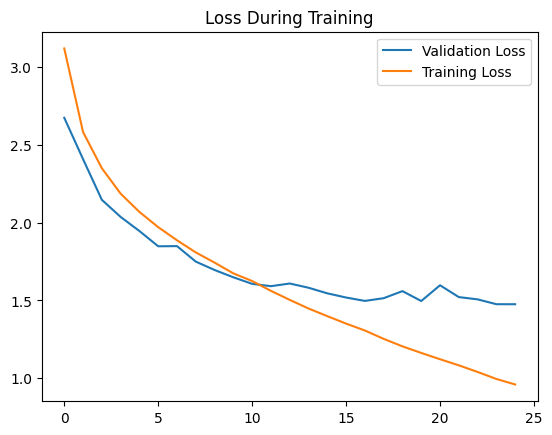

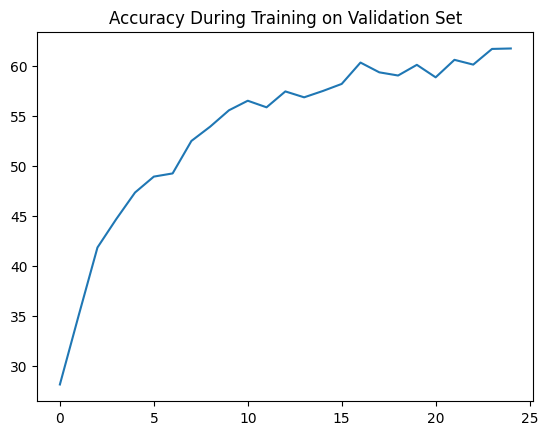

In [98]:
import matplotlib.pyplot as plt

plt.plot(test_los_per_epoch, label='Validation Loss')
plt.plot(train_loss_per_epoch, label='Training Loss')
plt.legend()
plt.title('Loss During Training')
plt.figure()
plt.plot(accuracy_per_epoch, label='Accuracy')
plt.title('Accuracy During Training on Validation Set')

In [97]:
torch.save(net,"train_85.26_test_61.71_more_batches.model")